# Monitorización de equipos industriales para detección de fallos


### 1. Importación de librerias

In [127]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from sklearn.metrics import r2_score
import optuna

### 2. Carga del csv

In [128]:
df = pd.read_csv("equipment_anomaly_data.csv")
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### 3. Detección de anomalías

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [130]:
df.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [131]:
df.isnull().sum()

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

In [132]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7667    False
7668    False
7669    False
7670    False
7671    False
Length: 7672, dtype: bool

In [133]:
df.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

### 4. Visualización de datos

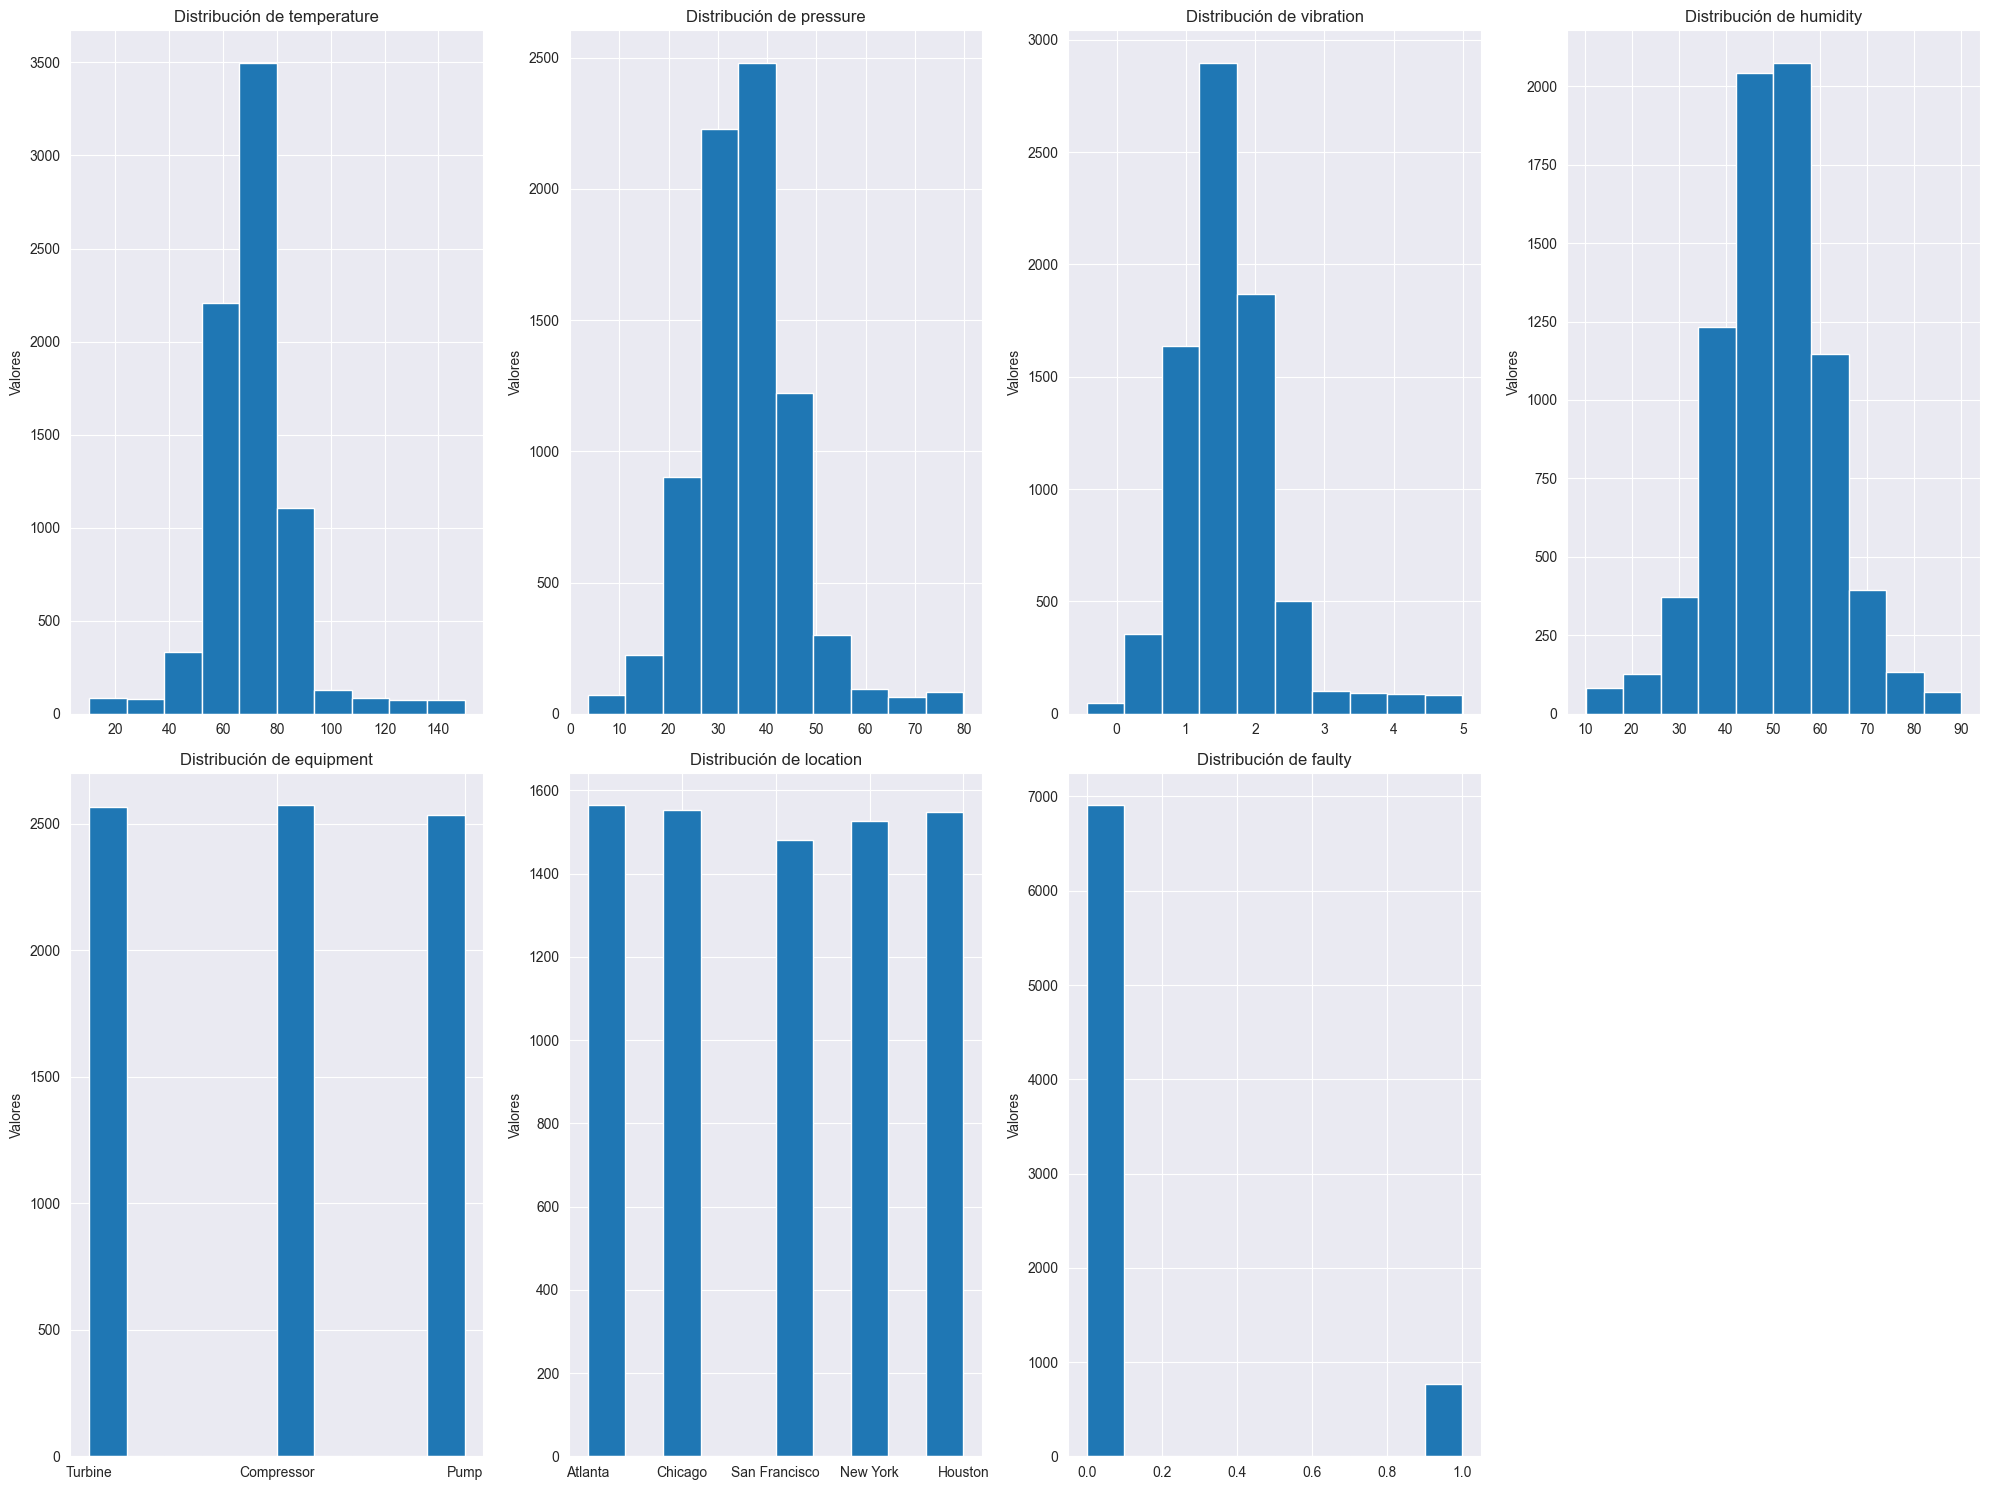

In [134]:
categorias = ['temperature', 'pressure', 'vibration', 'humidity', 'equipment','location', 'faulty']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].hist(df[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

In [135]:
df['equipment'].value_counts()

equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [136]:
df['location'].value_counts()

location
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

In [137]:
df['faulty'].value_counts()

faulty
0.0    6905
1.0     767
Name: count, dtype: int64

De acuerdo con la ingeniería de características realizaremos `OneHotEncoder` para `equipment` y para `location`, en el caso de `faulty` necesitaremos realizar resample porque hay demasiados defectuosos en comparación con los que no

### 5. Ingeniería de características

In [138]:
# Instanciar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Crea un array en vez de una matriz

# Aplicar el encoder a las columnas categóricas
categoricas = ['location', 'equipment']
valores = encoder.fit_transform(df[categoricas])

# Crear un DataFrame con los valores codificados
columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)

# Concatenar el DataFrame original con las columnas codificadas
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)

In [139]:
df.head()

,temperature,pressure,vibration,humidity,faulty,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco,equipment_Compressor,equipment_Pump,equipment_Turbine
0,58.180180,25.029278,0.606516,45.694907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,75.740712,22.954018,2.338095,41.867407,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,71.358594,27.276830,1.389198,58.954409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,71.616985,32.242921,1.770690,40.565138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,66.506832,45.197471,0.345398,43.253795,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [140]:
df.shape

(7672, 13)

In [141]:
# # Nos interesan los cuartiles del 25% y 75%
# categorias = ['temperature', 'pressure', 'vibration', 'humidity']
# Q1, Q3 = np.percentile(df['temperature'], [25, 75])
# IQR = Q3 - Q1
# outliers = []
# for elemento in df['temperature']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers.append(elemento)
# outliers

In [142]:
# df = df[~df['temperature'].isin(outliers)]
# df.shape

In [143]:
# Q1, Q3 = np.percentile(df['pressure'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['pressure']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [144]:
# df = df[~df['pressure'].isin(outliers2)]
# df.shape

In [145]:
# Q1, Q3 = np.percentile(df['vibration'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['vibration']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [146]:
# df = df[~df['vibration'].isin(outliers2)]
# df.shape

In [147]:
# Q1, Q3 = np.percentile(df['humidity'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['humidity']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [148]:
# df = df[~df['humidity'].isin(outliers2)]
# df.shape

Aplicando el rango intercuartílico hemos eliminado los outliers de las variables numericas, pero si recordamos la visaulización del prinicpio hemos visto que la variable objetivo tiene muchos datos de la clase 0 y muy pocos de la 1, vamos a reajustar este inconveniente

In [149]:
# # Supongamos que separamos clases mayoritaria y minoritaria
# df_major = df[df['faulty'] == 0]
# df_minor = df[df['faulty'] == 1]
# # Ahora hacemos oversampling de la clase minoritaria
# df_minor_oversampled = resample(df_minor,
# replace=True,n_samples=len(df_major), random_state=42)
# # Combinar las clases
# df_balanced = pd.concat([df_major, df_minor_oversampled])

In [150]:
# plt.hist(df_balanced['faulty'])

Después de aplicar `resample` se puede apreciar que las clases están equilibradas, a continuación se procederá al entrenamiento del modelo

### 6. Entrenamiento del modelo

Primero se escalará el dataframe ya que es de obligado cumplimiento para una red neuronal a diferencia de cualquier modelo de ML

In [151]:
X = df.drop('faulty',axis=1)
y = df['faulty']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos la red neuronal con 3 capas ocultas, todas de activación `relu` y un `Dropout` del 0.5 y 0.3 respectivamente por la reducción de capas ocultas a medida que el entrenamiento avanza

In [152]:
# Creamos el modelo de red neuronal
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential([
 Input(shape=(X_train.shape[1],)), # Definir forma de la entrada
    Dense(32, activation='relu'), # 1a capa oculta
    Dropout(0.5),
    Dense(16, activation='relu'), # 1a capa oculta
    Dropout(0.3),
    Dense(8, activation='relu'), # 2a capa oculta
    Dense(1, activation='sigmoid') # Salida
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Mostramos configuración
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6554 - loss: 0.6356 - val_accuracy: 0.8974 - val_loss: 0.3466
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9008 - loss: 0.3853 - val_accuracy: 0.8974 - val_loss: 0.2861
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9075 - loss: 0.3195 - val_accuracy: 0.9047 - val_loss: 0.2499
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.2823 - val_accuracy: 0.9235 - val_loss: 0.2182
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9294 - loss: 0.2542 - val_accuracy: 0.9381 - val_loss: 0.1864
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9334 - loss: 0.2409 - val_accuracy: 0.9487 - val_loss: 0.1656
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9373 - loss: 0.2309 - val_accuracy: 0.9520 - val_loss: 0.1499
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9413 - loss: 0.1897 - val_accuracy: 0.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0680
Pérdida: 0.07356040179729462, Precisión: 0.9791530966758728


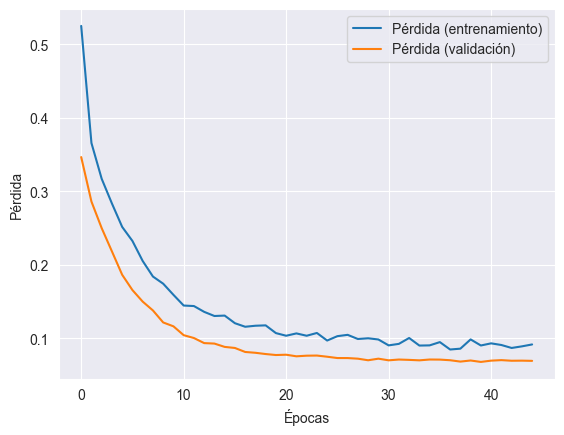

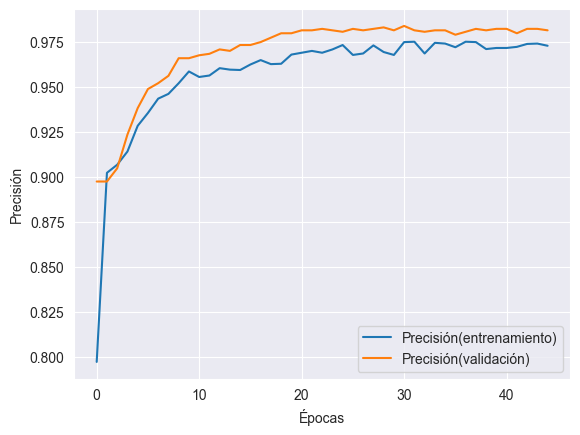

In [154]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['accuracy'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

A primera vista de las gráficas se puede apreciar un claro overfitting del modelo, en el cuál no se distingue en absoluto una mejoría

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.98      1.00      0.99      1377
   Mantenimiento       0.97      0.82      0.89       158

        accuracy                           0.98      1535
       macro avg       0.98      0.91      0.94      1535
    weighted avg       0.98      0.98      0.98      1535



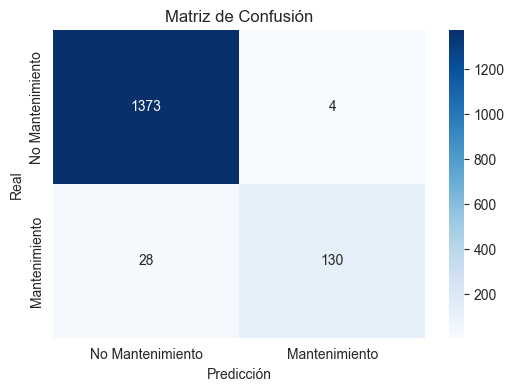

In [155]:
def train_validation(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Mantenimiento", "Mantenimiento"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mantenimiento", "Mantenimiento"],
                yticklabels=["No Mantenimiento", "Mantenimiento"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

Al igual que se visualizó con las gráficas, la matriz de confusión confirma lo afirmado, a continuación se realizará un ajuste de hiperparámetros mediante `RandomSearch` y `SMOTE` por el desbalanceo de clases

In [156]:
def build_model(hp):
 model = Sequential([
     Dense(units=hp.Int('units', min_value=32, max_value=512,step=32), activation='relu'),
     Dense(1)
 ])

 model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01])),loss='mean_squared_error',metrics=['mae'])
 return model

tuner = RandomSearch(
 build_model,
 objective='val_loss',
 max_trials=5,
 directory='./my_dir',
 project_name='prediccion'
)
tuner.search(X_train, y_train, validation_split=0.2)

Reloading Tuner from ./my_dir\prediccion\tuner0.json


In [157]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [158]:
best_model = tuner.hypermodel.build(best_hps)

In [159]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [160]:
#smote = SMOTE(random_state=42)
# X_resampled, y_train_split = smote.fit_resample(X_train_split, y_train_split)  # Solo en los datos de entrenamiento

In [161]:
# Ahora usa X_resampled, y_train_split en el entrenamiento
history = best_model.fit(X_train_split, y_train_split, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0614 - mae: 0.1692 - val_loss: 0.0315 - val_mae: 0.1111
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - mae: 0.1156 - val_loss: 0.0287 - val_mae: 0.1009
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273 - mae: 0.1016 - val_loss: 0.0255 - val_mae: 0.0949
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - mae: 0.0917 - val_loss: 0.0252 - val_mae: 0.0868
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mae: 0.0858 - val_loss: 0.0228 - val_mae: 0.0840
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - mae: 0.0818 - val_loss: 0.0237 - val_mae: 0.0770
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - mae: 0.0858 - val_loss: 0.0261 - val_mae: 0.0803
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - mae: 0.0765 - val_loss: 0.0233 - val_mae: 0.0760
Epoch 9/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.98      1.00      0.99      4429
   Mantenimiento       0.99      0.77      0.87       480

        accuracy                           0.98      4909
       macro avg       0.99      0.89      0.93      4909
    weighted avg       0.98      0.98      0.98      4909



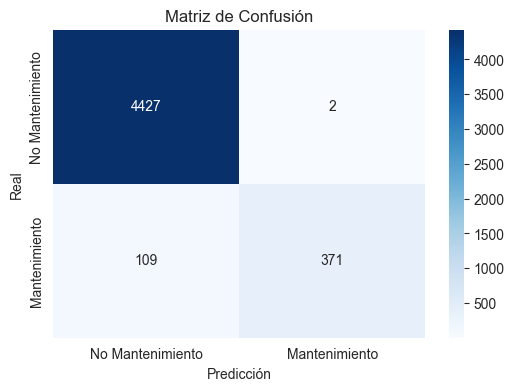

In [162]:
train_validation(best_model, X_train_split, y_train_split)

Ahora se puede apreciar una notoria mejoría con respecto al desempeño del modelo, donde se encuentra una precisión para la clase 0 del 0.99 y para la clase 1 una precisión del 0.94, así mismo, en la matriz de confusión se encuentra un número de falsos positivos bastante reducido en comparación con el resto de conclusiones

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 - mae: 0.0797
Pérdida: 0.0274302177131176, Precisión: 0.07903195917606354


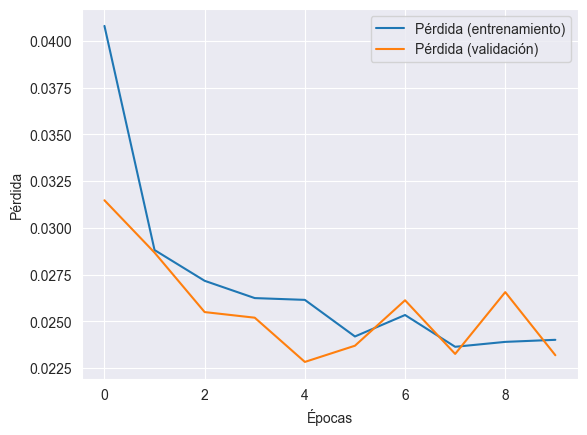

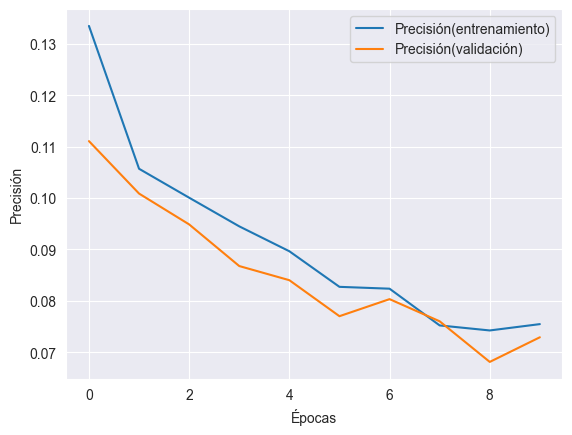

In [163]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['mae'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_mae'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [164]:
# Definir la función objetivo que Optuna optimizará
def objective(trial):
 # Espacios de búsqueda de hiperparámetros (esto son ejemplos)
 units = trial.suggest_int('units', 32, 512, step=32)
 lr = trial.suggest_categorical('learning_rate', [0.001, 0.01,0.1])

 # Crear el modelo
 model = Sequential([
    Input(shape=(X_train_split.shape[1],)), # Definir forma de la entrada
    Dense(units=units, activation='relu'),
    Dense(1, activation='sigmoid')
 ])

 model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss='mean_squared_error',metrics=['mae'])

 model.fit(X_train_split, y_train_split, epochs=50, validation_split=0.2, verbose=1)

 # Obtener la pérdida en la validación para optimizar
 val_loss = model.history.history['val_loss'][-1]
 return val_loss
# Crear estudio de Optuna y ejecutar la optimización
# Queremos minimizar la pérdida (val_loss)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) # 5 intentos de prueba, puedes aumentar este número
# Mostrar los mejores hiperparámetros encontrados
print(f'Best hyperparameters: {study.best_params}')


[I 2025-02-07 18:50:32,969] A new study created in memory with name: no-name-4660a9d8-8380-4dfc-bf62-398bc740dcc8


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1119 - mae: 0.1231 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0993 - mae: 0.0993 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0922 - mae: 0.0922 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1025 - mae: 0.1025 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0954 - mae: 0.0954 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0995 - mae: 0.0995 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0979 - mae: 0.0979 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0990 - mae: 0.0990 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-07 18:50:50,575] Trial 0 finished with value: 0.09164969623088837 and parameters: {'units': 224, 'learning_rate': 0.1}. Best is trial 0 with value: 0.09164969623088837.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0665 - mae: 0.1156 - val_loss: 0.0292 - val_mae: 0.0503
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - mae: 0.0458 - val_loss: 0.0228 - val_mae: 0.0396
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - mae: 0.0349 - val_loss: 0.0225 - val_mae: 0.0346
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - mae: 0.0293 - val_loss: 0.0205 - val_mae: 0.0298
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 - mae: 0.0284 - val_loss: 0.0274 - val_mae: 0.0327
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0218 - mae: 0.0278 - val_loss: 0.0219 - val_mae: 0.0274
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0265 - mae: 0.0336 - val_loss: 0.0210 - val_mae: 0.0274
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0201 - mae: 0.0268 - val_loss: 0.0165 - val_mae: 0.0205
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

[I 2025-02-07 18:51:14,673] Trial 1 finished with value: 0.03058493696153164 and parameters: {'units': 448, 'learning_rate': 0.01}. Best is trial 1 with value: 0.03058493696153164.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1016 - mae: 0.1124 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1091 - mae: 0.1091 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1091 - mae: 0.1091 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0930 - mae: 0.0930 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1005 - mae: 0.1005 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0975 - mae: 0.0975 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0959 - mae: 0.0959 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0980 - mae: 0.0980 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

[I 2025-02-07 18:51:34,084] Trial 2 finished with value: 0.09164969623088837 and parameters: {'units': 384, 'learning_rate': 0.1}. Best is trial 1 with value: 0.03058493696153164.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1119 - mae: 0.1237 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0972 - mae: 0.0972 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1048 - mae: 0.1048 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0974 - mae: 0.0974 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1062 - mae: 0.1062 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1044 - mae: 0.1044 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0989 - mae: 0.0989 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0968 - mae: 0.0968 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-07 18:51:50,210] Trial 3 finished with value: 0.09164969623088837 and parameters: {'units': 96, 'learning_rate': 0.1}. Best is trial 1 with value: 0.03058493696153164.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1364 - mae: 0.3238 - val_loss: 0.0570 - val_mae: 0.1536
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0537 - mae: 0.1448 - val_loss: 0.0431 - val_mae: 0.1168
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398 - mae: 0.1108 - val_loss: 0.0332 - val_mae: 0.1063
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - mae: 0.1015 - val_loss: 0.0262 - val_mae: 0.0935
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mae: 0.0864 - val_loss: 0.0220 - val_mae: 0.0860
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - mae: 0.0806 - val_loss: 0.0207 - val_mae: 0.0755
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mae: 0.0674 - val_loss: 0.0186 - val_mae: 0.0680
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.0582 - val_loss: 0.0182 - val_mae: 0.0643
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-07 18:52:06,521] Trial 4 finished with value: 0.013265811838209629 and parameters: {'units': 224, 'learning_rate': 0.001}. Best is trial 4 with value: 0.013265811838209629.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1113 - mae: 0.1225 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1013 - mae: 0.1013 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0952 - mae: 0.0952 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1046 - mae: 0.1046 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1058 - mae: 0.1058 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1006 - mae: 0.1006 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0955 - mae: 0.0955 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0940 - mae: 0.0940 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-07 18:52:22,850] Trial 5 finished with value: 0.09164969623088837 and parameters: {'units': 320, 'learning_rate': 0.1}. Best is trial 4 with value: 0.013265811838209629.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0744 - mae: 0.1279 - val_loss: 0.0366 - val_mae: 0.0710
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mae: 0.0514 - val_loss: 0.0281 - val_mae: 0.0538
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mae: 0.0446 - val_loss: 0.0224 - val_mae: 0.0401
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mae: 0.0331 - val_loss: 0.0233 - val_mae: 0.0332
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mae: 0.0228 - val_loss: 0.0216 - val_mae: 0.0320
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mae: 0.0274 - val_loss: 0.0240 - val_mae: 0.0319
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - mae: 0.0251 - val_loss: 0.0163 - val_mae: 0.0211
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - mae: 0.0220 - val_loss: 0.0228 - val_mae: 0.0307
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

[I 2025-02-07 18:52:39,538] Trial 6 finished with value: 0.028559189289808273 and parameters: {'units': 384, 'learning_rate': 0.01}. Best is trial 4 with value: 0.013265811838209629.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1325 - mae: 0.3125 - val_loss: 0.0559 - val_mae: 0.1535
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0544 - mae: 0.1428 - val_loss: 0.0422 - val_mae: 0.1192
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380 - mae: 0.1102 - val_loss: 0.0316 - val_mae: 0.1091
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mae: 0.0958 - val_loss: 0.0254 - val_mae: 0.0905
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.0858 - val_loss: 0.0223 - val_mae: 0.0831
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - mae: 0.0750 - val_loss: 0.0201 - val_mae: 0.0724
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mae: 0.0645 - val_loss: 0.0197 - val_mae: 0.0703
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mae: 0.0647 - val_loss: 0.0186 - val_mae: 0.0617
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-07 18:52:55,987] Trial 7 finished with value: 0.013069706968963146 and parameters: {'units': 224, 'learning_rate': 0.001}. Best is trial 7 with value: 0.013069706968963146.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1624 - mae: 0.3672 - val_loss: 0.0715 - val_mae: 0.1961
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0693 - mae: 0.1875 - val_loss: 0.0539 - val_mae: 0.1446
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0545 - mae: 0.1414 - val_loss: 0.0460 - val_mae: 0.1284
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0475 - mae: 0.1265 - val_loss: 0.0394 - val_mae: 0.1126
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0357 - mae: 0.1060 - val_loss: 0.0334 - val_mae: 0.1059
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0310 - mae: 0.1016 - val_loss: 0.0293 - val_mae: 0.1015
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - mae: 0.0967 - val_loss: 0.0260 - val_mae: 0.0945
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - mae: 0.0928 - val_loss: 0.0236 - val_mae: 0.0872
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-07 18:53:12,936] Trial 8 finished with value: 0.014293438754975796 and parameters: {'units': 64, 'learning_rate': 0.001}. Best is trial 7 with value: 0.013069706968963146.


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1042 - mae: 0.1154 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 - mae: 0.0950 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1023 - mae: 0.1023 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0990 - mae: 0.0990 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1006 - mae: 0.1006 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0979 - mae: 0.0979 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0983 - mae: 0.0983 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1060 - mae: 0.1060 - val_loss: 0.0916 - val_mae: 0.0916
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

[I 2025-02-07 18:53:29,566] Trial 9 finished with value: 0.09164969623088837 and parameters: {'units': 256, 'learning_rate': 0.1}. Best is trial 7 with value: 0.013069706968963146.


Best hyperparameters: {'units': 224, 'learning_rate': 0.001}


In [165]:
best_params = study.best_params  # Obtener los mejores hiperparámetros encontrados

# Crear y entrenar el mejor modelo
best_model = Sequential([
    Input(shape=(X_train_split.shape[1],)), # Definir forma de la entrada
    Dense(units=best_params['units'], activation='relu'),
    Dense(1, activation='sigmoid')  # Asegúrate de que la activación final sea adecuada
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='mean_squared_error',
    metrics=['mae']
)

best_model.fit(X_train_split, y_train_split, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1167 - mae: 0.2886 - val_loss: 0.0554 - val_mae: 0.1495
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513 - mae: 0.1376 - val_loss: 0.0432 - val_mae: 0.1147
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0404 - mae: 0.1094 - val_loss: 0.0326 - val_mae: 0.1064
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - mae: 0.0996 - val_loss: 0.0262 - val_mae: 0.0986
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mae: 0.0872 - val_loss: 0.0223 - val_mae: 0.0853
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mae: 0.0763 - val_loss: 0.0203 - val_mae: 0.0739
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0655 - val_loss: 0.0180 - val_mae: 0.0648
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - mae: 0.0640 - val_loss: 0.0171 - val_mae: 0.0583
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.99      1.00      1.00      4429
   Mantenimiento       0.99      0.93      0.96       480

        accuracy                           0.99      4909
       macro avg       0.99      0.96      0.98      4909
    weighted avg       0.99      0.99      0.99      4909



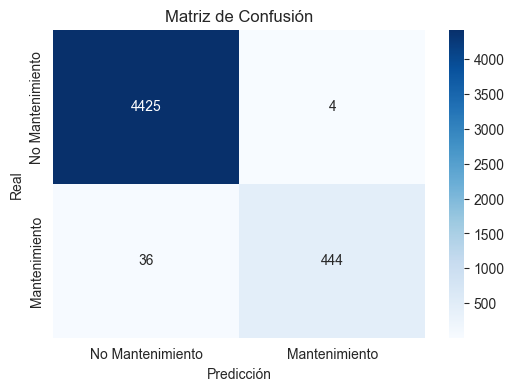

In [166]:
train_validation(best_model, X_train_split, y_train_split)

In [167]:
y_pred = best_model.predict(X_test).flatten()
y_test = np.array(y_test).flatten()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [168]:
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')

R² Score: 0.8132


### Nota: En este caso en específico no se ha realizado `resample` puesto que el modelo ha de aprender a diferenciar las que necesitan o no mantenimiento, y, dado que las de no mantenimiento son totalmente inferiores el modelo ha de adaptarse a esa inferioridad y discrepancia entre clases